## Principal Component Analysis (PCA)

This tutorial shows an example of PCA Classification. 

First import required packages. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import io
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Write a function to plot spectral curve (reflectance v. wavelength):

In [2]:
def PlotSpectraAndMean(Spectra, Wv, fignum):
    ### Spectra is NBands x NSamps
    mu = np.mean(Spectra, axis=1) #calculate mean of spectra
    print(np.shape(mu)) #print shape to confirm
    plt.figure(fignum)
    plt.plot(Wv, Spectra, 'c')
    plt.plot(Wv, mu, 'r')
    plt.show()
    return mu

Load spectra:

In [3]:
filename   = '../data/PaulGader/OSBSTinyIm.mat'
ImDict     = io.loadmat(filename)
OSBSTinyIm = ImDict['OSBSTinyIm']
TinySize   = np.shape(OSBSTinyIm)
NRows      = TinySize[0]
NCols      = TinySize[1]
NBands     = TinySize[2]
print('{0:4d} {1:4d} {2:4d}'.format(NRows, NCols, NBands))

  62  194  346


Get wavelengths:

(346, 1)


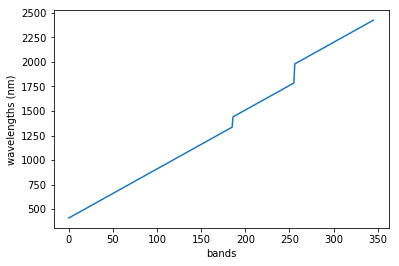

In [6]:
### LOAD WAVELENGTHS WITH WATER BANDS ###
### AND BAD BEGINNING AND ENDING BANDS REMOVED ###
Wv = io.loadmat('../data/PaulGader/NEONWvsNBB')
Wv = Wv['NEONWvsNBB']
print(np.shape(Wv))

plt.figure()
plt.plot(range(346), Wv)
plt.xlabel('bands'); plt.ylabel('wavelengths (nm)')

Let's load indices for Red, Green, and Blue for NEON hyperspectral data

In [7]:
### HAVE TO SUBTRACT AN OFFSET BECAUSE OF BAD BAND ###
### REMOVAL AND 0-BASED Python vs 1-Based MATLAB   ###
Offset     = 7

### LOAD & PRINT THE INDICES FOR THE COLORS   ###
### AND DIG THEM OUT OF MANY LAYERS OF ARRAYS ###
NEONColors = io.loadmat('../data/PaulGader/NEONColors.mat')
NEONRed    = NEONColors['NEONRed']
NEONGreen  = NEONColors['NEONGreen']
NEONBlue   = NEONColors['NEONBlue']
NEONNir    = NEONColors['NEONNir']
NEONRed    = NEONRed[0][0]-Offset
NEONGreen  = NEONGreen[0][0]-Offset
NEONBlue   = NEONBlue[0][0]-Offset
NEONNir    = NEONNir[0][0]-Offset
print('Indices:     {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRed, NEONGreen, NEONBlue, NEONNir))

### CONVERT THE INDICES TO WAVELENGTHS ###
NEONRedWv    = Wv[NEONRed][0]
NEONGreenWv  = Wv[NEONGreen][0]
NEONBlueWv   = Wv[NEONBlue][0]
NEONNirWv    = Wv[NEONNir][0]
print('Wavelengths: {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRedWv, NEONGreenWv, NEONBlueWv, NEONNirWv))

Indices:       47   25    6  119
Wavelengths:  645  535  440 1005


Now we can make a color image and display it

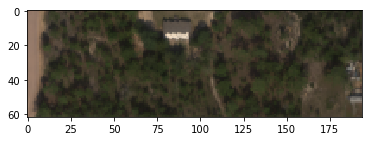

In [8]:
RGBIm = OSBSTinyIm[:, :, [NEONRed, NEONGreen, NEONBlue]]
RGBIm = np.sqrt(RGBIm)
plt.figure()
plt.imshow(RGBIm)
plt.show()

Now let's turn the image into a sequence of vectors
so we can use matrix algebra

In [9]:
### HAVE TO TAKE INTO ACCOUNT DIFFERENCES BETWEEN Python AND Matlab ###
### Python USES THE    C     PROGRAMMING LANGUAGE ORDERING ###
### MATLAB USERS THE FORTRAN PROGRAMMING LANGUAGE ORDERING ###
### Python WOULD RESHAPE BY REFERENCE AND MATLAB BY VALUE  ###
### THEREFORE, WE NEED TO COPY THE VALUES EXPLICITLY       ###
TinyVecs = OSBSTinyIm.reshape(NRows*NCols, NBands, order='F').copy()

### MATLAB TREATS THE ROWS AS DATA SAMPLES ###
### np  TREATS THE COLS AS DATA SAMPLES ###
TinyVecs = np.transpose(TinyVecs)
NSamps   = np.shape(TinyVecs)[1]
np.shape(TinyVecs)

(346, 12028)

In [12]:
### EXERCISE
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
mymu        = PlotSpectraAndMean(SomeSpectra, Wv, 3)

range(1000, 2000, 100)


In [13]:
np.shape(mymu)

(346,)

Let's plot some spectra

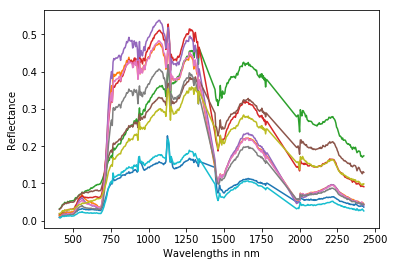

In [14]:
### Indices of Spectra to Try ###
### SpecIndices = range(0, 1000, 100) ###
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
plt.figure(3)
plt.plot(Wv, SomeSpectra)
plt.xlabel('Wavelengths in nm')
plt.ylabel('Reflectance')
plt.show()

Compute the Average Spectrum and plot it


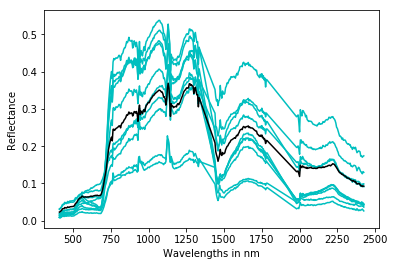

In [15]:
mu = np.mean(TinyVecs, axis=1)
plt.figure(4)
plt.plot(Wv, SomeSpectra, 'c') #plot sample of some spectra
plt.plot(Wv, mu, 'k') #plot mean spectra for the entire image in black
plt.xlabel('Wavelengths in nm')
plt.ylabel('Reflectance')
plt.show()

Now we want to subtract the mean from every sample

In [16]:
np.shape(mu)

(346,)

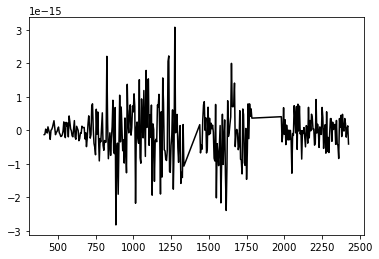

In [17]:
TinyVecsZ = np.zeros((NBands, NSamps))

#subtract mean spectra from each pixel's spectra
for n in range(NSamps):
    TinyVecsZ[range(NBands),n]= TinyVecs[(range(NBands), n)]-mu

muz = np.mean(TinyVecsZ, axis=1)
plt.figure(5)
plt.plot(Wv, muz, 'k')
#plt.ylim(-1,1)
plt.show()

Let's make the covariance

In [20]:
C = np.cov(TinyVecs)
np.shape(C)

(346, 346)

We can look at some of the values but too many to look at them all.
We can also view C as an image

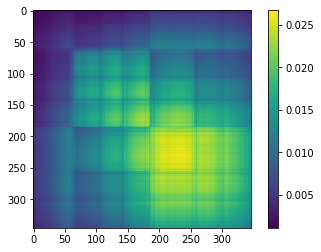

In [22]:
#correlations between different bands; axes are band indices
plt.figure(6)
plt.imshow(C); plt.colorbar()
plt.show()

#this is absolute variance, not relative variance (normalized to mean)
#signal can be dominated by NIR since the reflectance values are much larger than in the visible portion 

In [24]:
# PRINT OUT SOME "AMPLIFIED" COVARIANCE VALUES %%%
for cn in range(0, 50,5):
    w = int(Wv[cn])
    if cn==0:
        print("     ", end=" ")
    else:
        print('{0:5d}'.format(w), end=" ")
print('\n')

for rn in range(5, 50, 5):
    w = int(Wv[rn])
    print('{0:5d}'.format(w), end=" ")
    for cn in range(5,50,5):
        CovVal = int(100000*C[rn, cn])
        print('{0:5d}'.format(CovVal), end=" ")
    print('\n')
    
#print(round(100000*C[NEONBlue, NEONNir]))
#print(round(100000*C[NEONGreen, NEONNir]))
#print(round(100000*C[NEONRed, NEONNir]))
#print(round(100000*C[NEONGreen, NEONRed]))

        435   460   485   510   535   560   585   610   635 

  435   166   181   193   201   215   238   261   275   293 

  460   181   198   211   220   236   261   286   302   321 

  485   193   211   226   235   252   280   306   324   344 

  510   201   220   235   245   264   293   321   339   361 

  535   215   236   252   264   289   322   350   369   391 

  560   238   261   280   293   322   360   391   412   437 

  585   261   286   306   321   350   391   428   453   481 

  610   275   302   324   339   369   412   453   479   510 

  635   293   321   344   361   391   437   481   510   544 



Notice that there are no negative values.  Why?

Weird covariance because they are all above their mean at the same time or below the mean at the same time -- positive correlation. 

This is likely because of illumination

What if we normalize the vectors to have magnitude 1 (common strategy)

norm of a vector is the square root of the sum of the squares (pythagorean theorem)

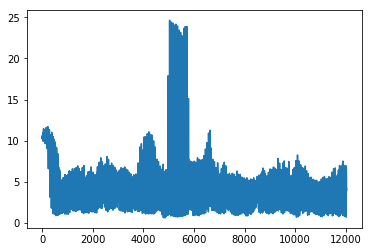

In [25]:
Norms = np.sqrt(np.sum(TinyVecs*TinyVecs, axis=0))
plt.figure(7)
plt.plot(Norms)
### Too many Norms.  How do we fix?
plt.show()

In [26]:
# High norms correspond to the roof on the house
print(np.shape(Norms))
print(np.shape(TinyVecs))

(12028,)
(346, 12028)


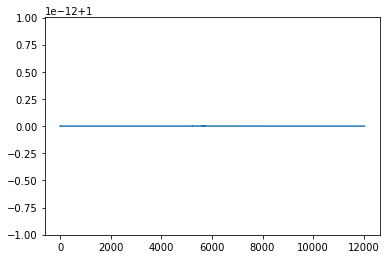

1.000000 1.000000


In [27]:
### Allocate Memory
TinyVecsNorm = np.zeros((NBands, NSamps))
for samp in range(NSamps):
    NormSamp = Norms[samp]
    for band in range(NBands):
        TinyVecsNorm[band, samp] = TinyVecs[band,samp]/NormSamp
        
#check that the norm of the norm is one
Norms1 = np.sqrt(np.sum(TinyVecsNorm*TinyVecsNorm, axis=0))
plt.figure(7)
plt.plot(Norms1)
plt.show()
BigNorm = np.max(Norms1)
LitNorm = np.min(Norms1)
print('{0:4f} {1:4f}'.format(BigNorm, LitNorm))
### Too many Norms.  How do we fix?

Exercise:  Turn the script for plotting spectra and their mean above into a function

(346,)


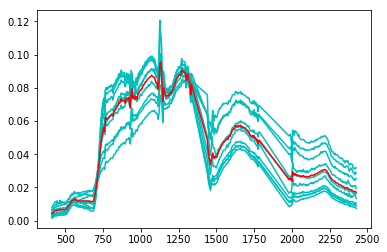

In [28]:
### Plot normalized spectra & mean in red -- this is much tighter than it used to be
SpecIndices     = range(1000, 2000, 100)
SomeSpectraNorm = TinyVecsNorm[:, range(1000, 2000, 100)]
MuNorm          = PlotSpectraAndMean(SomeSpectraNorm, Wv, 3)

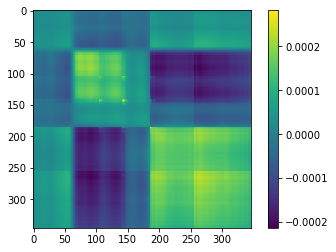

-0.000213907629112
0.000281867544679


In [32]:
#plot covariance of normalized vectors 
CNorm = np.cov(TinyVecsNorm)
plt.figure()
plt.imshow(CNorm); plt.colorbar()
plt.show()
print(np.amin(CNorm))
print(np.amax(CNorm))

In [31]:
# PRINT OUT SOME "AMPLIFIED" COVARIANCE VALUES %%%
for cn in range(0, 50,5):
    w = int(Wv[cn])
    if cn==0:
        print("     ", end=" ")
    else:
        print('{0:5d}'.format(w), end=" ")
print('\n')


for rn in range(5, 50, 5):
    w = int(Wv[rn])
    print('{0:5d}'.format(w), end=" ")
    for cn in range(5,50,5):
        CovVal = int(10000000*CNorm[rn, cn])
        print('{0:5d}'.format(CovVal), end=" ")
    print('\n')

        435   460   485   510   535   560   585   610   635 

  435   253   259   267   263   245   258   298   317   336 

  460   259   269   278   275   257   271   315   335   356 

  485   267   278   289   286   267   282   329   351   373 

  510   263   275   286   284   267   283   331   353   375 

  535   245   257   267   267   263   281   318   334   350 

  560   258   271   282   283   281   303   341   358   374 

  585   298   315   329   331   318   341   397   423   449 

  610   317   335   351   353   334   358   423   455   486 

  635   336   356   373   375   350   374   449   486   523 



In [33]:
#calculate covariance of different indices by selecting bands of interest
print(np.shape(TinyVecs))
print(NEONNir)
print(NEONRed)
NIRVals  = TinyVecs[NEONNir, range(NSamps)] 
RedVals  = TinyVecs[NEONRed, range(NSamps)]
NDVIVals = (NIRVals-RedVals)/(NIRVals+RedVals)
np.shape(NDVIVals)
NDVIIm   = np.reshape(NDVIVals,(NRows, NCols),order='F') #NDVI covariance
#reshape to convert from mat indices to Python; F = fortran

(346, 12028)
119
47


In [34]:
print(np.shape(NDVIIm))

(62, 194)


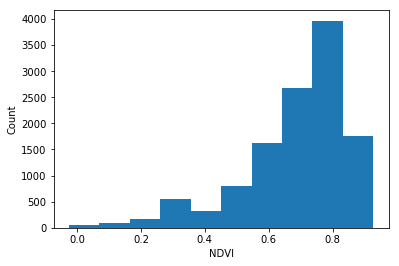

In [37]:
plt.figure()
plt.hist(NDVIVals); plt.xlabel('NDVI'); plt.ylabel('Count')
plt.show()

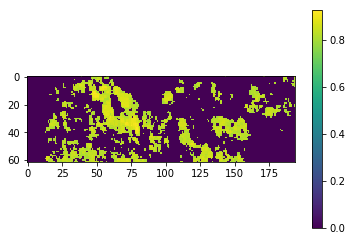

In [38]:
#Look only at NDVI greater than 0.8
HiNDVI = NDVIIm*(NDVIIm>0.8) #another way to mask -- multiply by boolean matrix
plt.figure()
plt.imshow(HiNDVI); #plt.colorbar()
plt.show()

In [39]:
# plt.figure()
# plt.plot(nonzero(NDVIVals>0.8))
# plt.show()
VegIndices = np.nonzero(NDVIVals>0.8)
# print(VegIndices[0])
print(np.shape(VegIndices))
# print(np.shape(TinyVecs))
VegSpectra = TinyVecs[:, VegIndices[0]]
print(np.shape(VegSpectra))

(1, 3136)
(346, 3136)


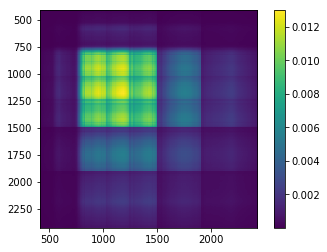

In [40]:
#Plot covariance of vegetation (defined as NDVI > 0.8)
CVeg = np.cov(VegSpectra)
plt.figure(9)
plt.imshow?
plt.imshow(CVeg,extent=(np.amin(Wv), np.amax(Wv),np.amax(Wv), np.amin(Wv)))
plt.colorbar()
plt.show()

In [ ]:
#positive covariance in NIR bands (750-1500nm?) --> vegetation

OK, Let's do PCA

Recall that TinyVecsZ is the mean-subtracted version of the original spectra 

In [41]:
C   = np.cov(TinyVecs)
D,V = linalg.eig(C) #calculates eigenvalues
D   = D.real #Python gives you eigenvalues as complex numbers ; 
             #covariance will never have complex numbers, so extract only the real portion 
print(np.shape(D)) #
print(np.shape(V))
print(TinyVecs.shape)
print(V[0,0])

(346,)
(346, 346)
(346, 12028)
-0.0124822914573


$$S = V^TDV$$

In [60]:
# plt.figure(10)
print(D.shape)
DiagD = np.diag(D)
print('Diagonal Shape:',DiagD.shape)

(346,)
Diagonal Shape: (346, 346)


(346,)


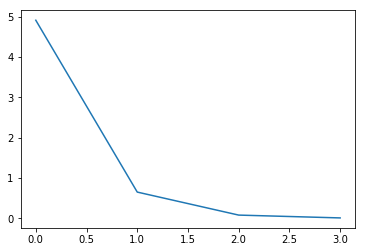

In [53]:
print(D.shape) #Diagonal matrix is an array with 346 elements - this differs from Matlab
plt.plot(D[0:4]) # plot only first 5 eigenvalues
#Exercise
#plt.plot(D[range(10)])
#plt.plot(D[range(10, 30, 10)])
plt.show()

There are 346 eigenvalues, but only the first few contain information. By the second coordinate, the eigenvalue drops below 1. According to PCA, this data does not have many dimensions (~3).

In [57]:
TinyVecsPCA = np.dot(V.T, TinyVecsZ) #V transpose times x - mean
PCACovar    = np.cov(TinyVecsPCA)
D,V         = linalg.eig(C)
D           = D.real
print(D.shape)
print(PCACovar.shape)
for r in range(10):
    print('{0:5f} {1:5f}'.format(D[r], PCACovar[r,r]))
print()
for r in range(10):
    for c in range(10):
        NextVal = int(10000*PCACovar[r,c])
        print('{0:5d}'.format(NextVal), end=" ")
    print('\n')
# #Delta       = np.sum(np.sum((PCACovar-D), axis=0), axis=0)
# print(Delta)
# plt.figure(11)
# plt.plot(np.diag(PCACovar))
# plt.show()

(346,)
(346, 346)
4.911250 4.911250
0.653442 0.653442
0.083168 0.083168
0.013260 0.013260
0.004038 0.004038
0.003201 0.003201
0.001390 0.001390
0.000931 0.000931
0.000705 0.000705
0.000561 0.000561

49112     0     0     0     0     0     0     0     0     0 

    0  6534     0     0     0     0     0     0     0     0 

    0     0   831     0     0     0     0     0     0     0 

    0     0     0   132     0     0     0     0     0     0 

    0     0     0     0    40     0     0     0     0     0 

    0     0     0     0     0    32     0     0     0     0 

    0     0     0     0     0     0    13     0     0     0 

    0     0     0     0     0     0     0     9     0     0 

    0     0     0     0     0     0     0     0     7     0 

    0     0     0     0     0     0     0     0     0     5 



Notice that the values on the diagonal are the variances of each coordinate in the PCA transformed data.  They drop off rapidly which is why one can reduce dimensionality by discarding components that have low variance.  Also, notice that the diagonal matrix D produce by diagonalizing the covariance of x is the covariance of y = PCA(x).

If the data are Gaussian, then the coordinates of y are uncorrelated and independent.  If not, then only uncorrelated.

Let's pull out the first 3 dimensions and plot them'

<IPython.core.display.Javascript object>


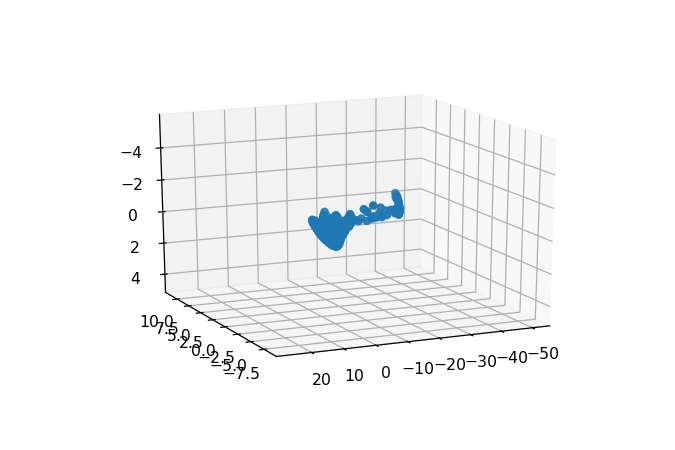

In [56]:
%matplotlib notebook #interactive mode so you can rotate
fig = plt.figure(13)
ax = fig.add_subplot(111, projection='3d') #make 3D plot
#plot only 0th,1st, & 2nd elements
ax.scatter(TinyVecsPCA[0,range(NSamps)],TinyVecsPCA[1,range(NSamps)],TinyVecsPCA[2,range(NSamps)], marker='o')
plt.show()

We can also display principal components as images

<IPython.core.display.Javascript object>


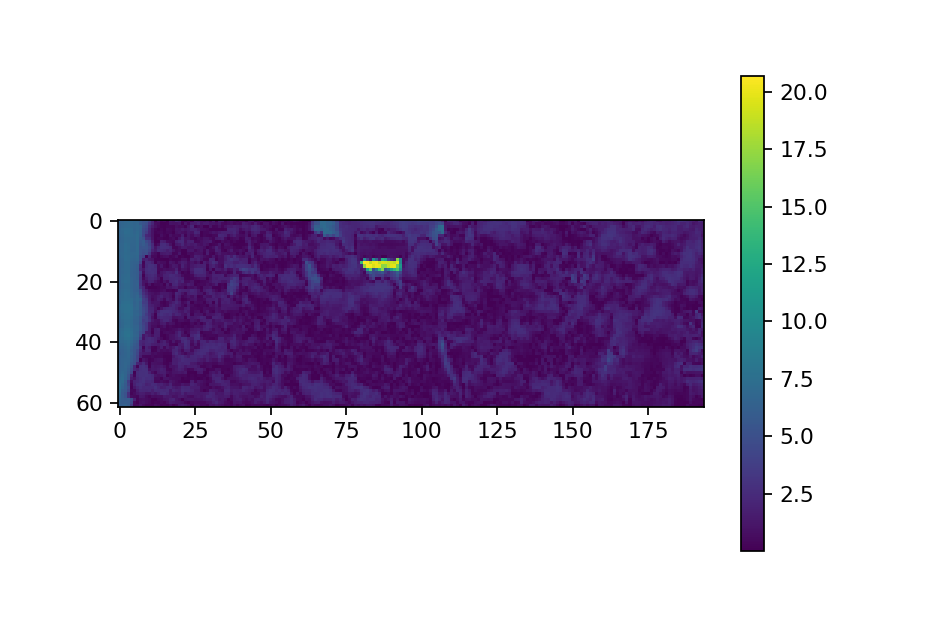

<IPython.core.display.Javascript object>


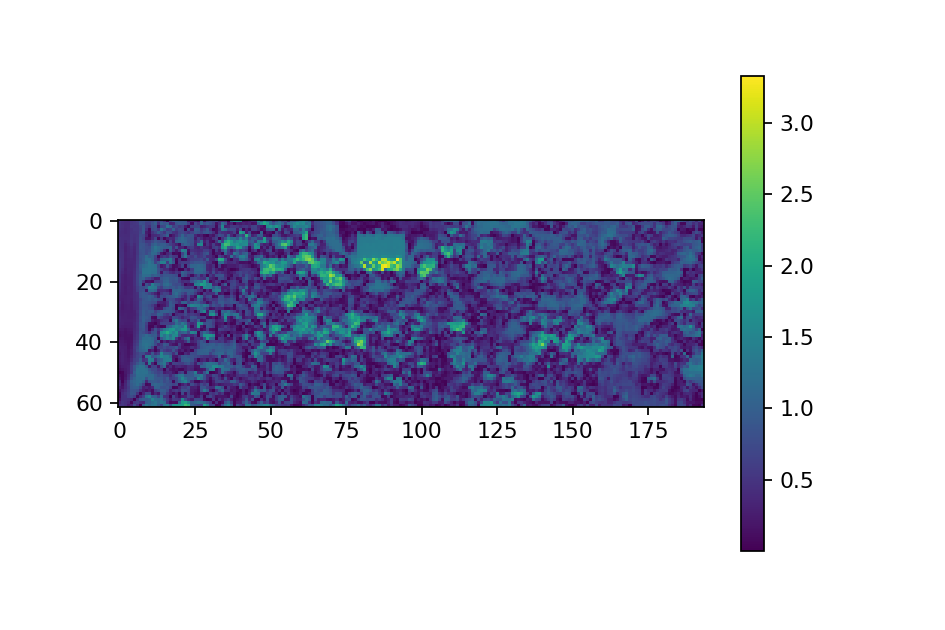

<IPython.core.display.Javascript object>


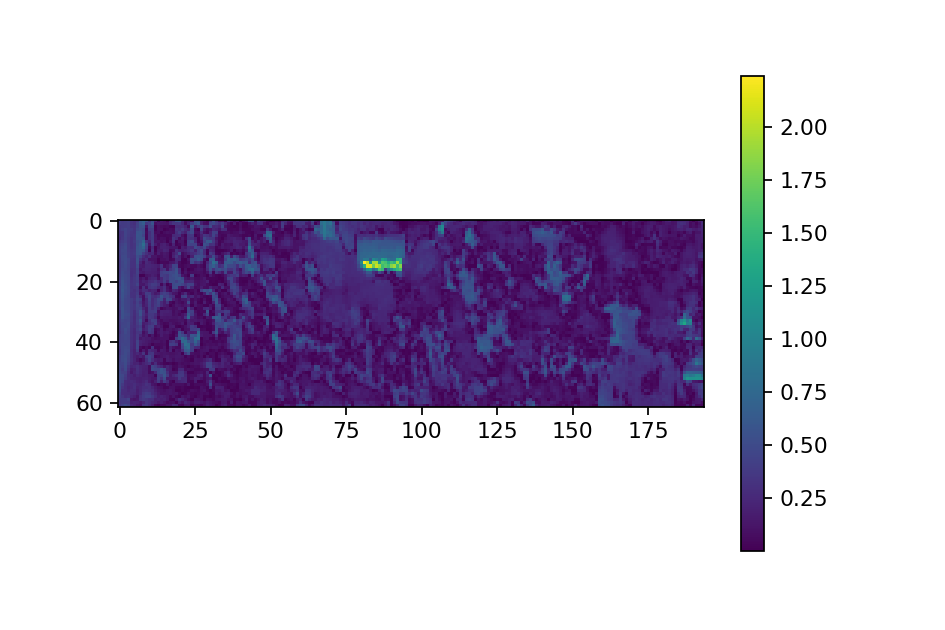

In [58]:
for coord in range(3):
    P1 = TinyVecsPCA[coord, :]
    PCAIm      = np.reshape(P1, (NRows, NCols), order='F')
    plt.figure(14+coord)
    plt.imshow(np.abs(PCAIm))
    plt.colorbar()
    plt.show()

#### EXERCISE:  
Write a function that calculates PCA of spectra and plots the first 3 components.